# Lottery Ticket Hypothesis: _Conv-4_ CNN for CIFAR10

Implementation of the hypothesis using 4 convolutional layers with the following architecture:

1. __Convolutional Layers:__ 64, 64, pool
1. __Convolutional Layers:__ 128, 128, pool
1. __Dense Layers:__ 256, 256, 10

Filter/Kernel size for convolutional layers is 3 x 3, with padding and stride of 1.

Filter and Stride for max-pooling layers is 2 x 2

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math
import tensorflow_model_optimization as tfmot
from tensorflow_model_optimization.sparsity import keras as sparsity
# from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
from tensorflow.keras.layers import AveragePooling2D, Conv2D, MaxPooling2D, ReLU
from tensorflow.keras import models, layers, datasets
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, InputLayer
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.initializers import RandomNormal
# import math
from sklearn.metrics import accuracy_score, precision_score, recall_score

/opt/conda/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:544: FutureWa

In [2]:
tf.__version__

'2.0.0'

In [3]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES = 1

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=1


In [4]:
batch_size = 60
num_classes = 10
num_epochs = 100

In [5]:
# Data preprocessing and cleaning:
# input image dimensions
img_rows, img_cols = 32, 32

# Load CIFAR-10 dataset-
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [6]:
if tf.keras.backend.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 3, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 3, img_rows, img_cols)
    input_shape = (3, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 3)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 3)
    input_shape = (img_rows, img_cols, 3)

print("\n'input_shape' which will be used = {0}\n".format(input_shape))


'input_shape' which will be used = (32, 32, 3)



In [7]:
# Convert datasets to floating point types-
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# Normalize the training and testing datasets-
X_train /= 255.0
X_test /= 255.0

In [8]:
# convert class vectors/target to binary class matrices or one-hot encoded values-
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

In [9]:
print("\nDimensions of training and testing sets are:")
print("X_train.shape = {0}, y_train.shape = {1}".format(X_train.shape, y_train.shape))
print("X_test.shape = {0}, y_test.shape = {1}".format(X_test.shape, y_test.shape))


Dimensions of training and testing sets are:
X_train.shape = (50000, 32, 32, 3), y_train.shape = (50000, 10)
X_test.shape = (10000, 32, 32, 3), y_test.shape = (10000, 10)


### Prepare CIFAR10 dataset for _GradientTape_ training:

In [10]:
# Create training and testing datasets-
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [11]:
train_dataset = train_dataset.shuffle(buffer_size = 20000, reshuffle_each_iteration = True).batch(batch_size = batch_size, drop_remainder = False)

In [12]:
test_dataset = test_dataset.batch(batch_size=batch_size, drop_remainder=False)

In [13]:
# Choose an optimizer and loss function for training-
loss_fn = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(lr = 0.0003)

In [14]:
# Select metrics to measure the error & accuracy of model.
# These metrics accumulate the values over epochs and then
# print the overall result-
train_loss = tf.keras.metrics.Mean(name = 'train_loss')
train_accuracy = tf.keras.metrics.CategoricalAccuracy(name = 'train_accuracy')

test_loss = tf.keras.metrics.Mean(name = 'test_loss')
test_accuracy = tf.keras.metrics.CategoricalAccuracy(name = 'test_accuracy')

In [15]:
def conv4_cnn():
    """
    Function to define the architecture of a neural network model
    following Conv-2 architecture for CIFAR-10 dataset and using
    provided parameter which are used to prune the model.
    
    Conv-2 architecture-
    64, 64, pool    -- convolutions
    128, 128, pool  -- convolutions
    256, 256, 10    -- fully connected layers
    
    
    Output: Returns designed and compiled neural network model
    """
    
    model = Sequential()
    
    model.add(
        Conv2D(
            filters = 64, kernel_size = (3, 3),
            activation='relu', kernel_initializer = tf.initializers.GlorotNormal(),
            strides = (1, 1), padding = 'same',
            input_shape=(32, 32, 3)
            )
    )

    model.add(
        Conv2D(
            filters = 64, kernel_size = (3, 3),
            activation='relu', kernel_initializer = tf.initializers.GlorotNormal(),
            strides = (1, 1), padding = 'same'
            )
    )
    
    model.add(
        MaxPooling2D(
            pool_size = (2, 2),
            strides = (2, 2)
        )
    )
    
    model.add(
        Conv2D(
            filters = 128, kernel_size = (3, 3),
            activation='relu', kernel_initializer = tf.initializers.GlorotNormal(),
            strides = (1, 1), padding = 'same',
            input_shape=(32, 32, 3)
            )
    )

    model.add(
        Conv2D(
            filters = 128, kernel_size = (3, 3),
            activation='relu', kernel_initializer = tf.initializers.GlorotNormal(),
            strides = (1, 1), padding = 'same'
            )
    )
    
    model.add(
        MaxPooling2D(
            pool_size = (2, 2),
            strides = (2, 2)
        )
    )

    model.add(Flatten())
    
    model.add(
        Dense(
            units = 256, activation='relu',
            kernel_initializer = tf.initializers.GlorotNormal()
        )
    )
    
    model.add(
        Dense(
            units = 256, activation='relu',
            kernel_initializer = tf.initializers.GlorotNormal()
        )
    )
    
    model.add(
        Dense(
            units = 10, activation='softmax'
        )
    )
    

    # Compile pruned CNN-
    model.compile(
        loss=tf.keras.losses.categorical_crossentropy,
        # optimizer='adam',
        optimizer=tf.keras.optimizers.Adam(lr = 0.0003),
        metrics=['accuracy']
    )
    
    
    return model


In [16]:
# Initialize a Conv-4 CNN model-
orig_model = conv4_cnn()

In [17]:
# Save random weights-
orig_model.save_weights("Conv4_CIFAR10_Random_Gaussian_GLorot_Weights.h5", overwrite=True)

In [18]:
# Get CNN summary-
# orig_model_stripped.summary()
orig_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0

In [57]:
import tensorflow.keras.backend as K


trainable_wts = np.sum([K.count_params(w) for w in orig_model.trainable_weights])
non_trainable_wts = np.sum([K.count_params(w) for w in orig_model.non_trainable_weights])

print("\nNumber of training weights = {0} and non-trainabel weights = {1}\n".format(
    trainable_wts, non_trainable_wts
))
print("Total number of parameters = {0}\n".format(trainable_wts + non_trainable_wts))



Number of training weights = 2425930 and non-trainabel weights = 0.0

Total number of parameters = 2425930.0



In [58]:
total_params = trainable_wts

### Layer-wise pruning:
The Lottery Ticket Hypothesis follows a _layer-wise pruning_ heuristic for __Conv-4__ CNN for CIFAR-10 dataset. 

The rate of layer-wise pruning is as follows (per iterative pruning round):

1. __convolutional layers:__ 10%
1. __fully-connected layers:__ 20%
1. __output layer:__ 10%

Therefore, there is a need to compute the percentage of weights being pruned for each layer.

In [38]:
def compute_layer_wise_pruning(conv_layer_pruning_rate, fully_connected_pruning_rate, output_layer_pruning_rates):
    '''
    Function to compute layer-wise pruning for Conv-4 CNN using
    CIFAR-10 dataset.
    
    Inputs:
    conv_layer_pruning_rate:         pruning rate for conv layer
    fully_connected_pruning_rate:    pruning rate for dense layer
    output_layer_pruning_rates:      pruning rate for output layer
    
    Returns:
    layer_wise_pruning:              python dict containing layer-wise pruning rates
    n:                               number of pruning rounds
    '''
    
    # number of convolutional parameters-
    conv1 = 1792
    conv2 = 36928
    conv3 = 73856
    conv4 = 147584


    # number of fully-connected dense parameters-
    dense1 = 2097408
    dense2 = 65792
    op_layer = 2570

    # total number of parameters-
    total_params = conv1 + conv2 + conv3 + conv4 + dense1 + dense2 + op_layer
    print("\nTotal number of trainable parameters = {0}\n".format(total_params))
    
    # maximum pruning performed is till 0.5% of all parameters-
    max_pruned_params = 0.005 * total_params
    
    loc_tot_params = total_params
    loc_conv1 = conv1
    loc_conv2 = conv2
    loc_conv3 = conv3
    loc_conv4 = conv4
    loc_dense1 = dense1
    loc_dense2 = dense2
    loc_op_layer = op_layer

    # variable to count number of pruning rounds-
    n = 0
    
    # Lists to hold percentage of weights pruned in each round for all layers in CNN-
    conv1_pruning = []
    conv2_pruning = []
    conv3_pruning = []
    conv4_pruning = []
    dense1_pruning = []
    dense2_pruning = []
    op_layer_pruning = []
    
    
    conv_layer_pruning_rate = conv_layer_pruning_rate / 100
    fully_connected_pruning_rate = fully_connected_pruning_rate / 100
    output_layer_pruning_rate = output_layer_pruning_rates / 100
    '''
    print("\nPruning rates to be used for computations:")
    print("conv layer = {0:.2f}, dense layer = {1:.2f} & output layer = {2:.2f}\n".format(
        conv_layer_pruning_rate, fully_connected_pruning_rate, output_layer_pruning_rate
    ))
    '''

    while loc_tot_params >= max_pruned_params:
        '''
        loc_conv1 *= 0.9    # 10% weights are pruned
        loc_conv2 *= 0.9    # 10% weights are pruned
        loc_conv3 *= 0.9	# 10% weights are pruned
        loc_conv4 *= 0.9	# 10% weights are pruned
        loc_dense1 *= 0.8   # 20% weights are pruned
        loc_dense2 *= 0.8   # 20% weights are pruned
        loc_op_layer *= 0.9 # 10% weights are pruned
        '''
        
        loc_conv1 *= (1 - conv_layer_pruning_rate)     # 10% weights are pruned
        loc_conv2 *= (1 - conv_layer_pruning_rate)     # 10% weights are pruned
        loc_conv3 *= (1 - conv_layer_pruning_rate)     # 10% weights are pruned
        loc_conv4 *= (1 - conv_layer_pruning_rate)     # 10% weights are pruned
        loc_dense1 *= (1 - fully_connected_pruning_rate)     # 20% weights are pruned
        loc_dense2 *= (1 - fully_connected_pruning_rate)     # 20% weights are pruned
        loc_op_layer *= (1 - output_layer_pruning_rate)     # 10% weights are pruned
        
        
        conv1_pruning.append(((conv1 - loc_conv1) / conv1) * 100)
        conv2_pruning.append(((conv2 - loc_conv2) / conv2) * 100)
        conv3_pruning.append(((conv3 - loc_conv3) / conv3) * 100)
        conv4_pruning.append(((conv4 - loc_conv4) / conv4) * 100)
        dense1_pruning.append(((dense1 - loc_dense1) / dense1) * 100)
        dense2_pruning.append(((dense2 - loc_dense2) / dense2) * 100)
        op_layer_pruning.append(((op_layer - loc_op_layer) / op_layer) * 100)

        loc_tot_params = loc_conv1 + loc_conv2 + loc_conv3 + loc_conv4 + loc_dense1 + \
        loc_dense2 + loc_op_layer

        n += 1

        '''
        print("\nConv1 = {0:.3f}, Conv2 = {1:.3f}".format(loc_conv1, loc_conv2))
        print("Dense1 = {0:.3f}, Dense2 = {1:.3f} & O/p layer = {2:.3f}".format(
            loc_dense1, loc_dense2, loc_op_layer))
        print("Total number of parameters = {0:.3f}\n".format(loc_tot_params))
        '''
    
    # print("\nnumber of pruning rounds = {0}\n\n".format(n))
    
    # Convert from list to np.array-
    conv1_pruning = np.array(conv1_pruning)
    conv2_pruning = np.array(conv2_pruning)
    conv3_pruning = np.array(conv3_pruning)
    conv4_pruning = np.array(conv4_pruning)
    dense1_pruning = np.array(dense1_pruning)
    dense2_pruning = np.array(dense2_pruning)
    op_layer_pruning = np.array(op_layer_pruning)
    
    
    # Round off numpy arrays to 3 decimal digits-
    conv1_pruning = np.round(conv1_pruning, decimals=3)
    conv2_pruning = np.round(conv2_pruning, decimals=3)
    conv3_pruning = np.round(conv3_pruning, decimals = 3)
    conv4_pruning = np.round(conv4_pruning, decimals = 3)
    dense1_pruning = np.round(dense1_pruning, decimals=3)
    dense2_pruning = np.round(dense2_pruning, decimals=3)
    op_layer_pruning = np.round(op_layer_pruning, decimals=3)


    # Python dict to hold layer-wise pruning computations-
    layer_wise_pruning = {}
    
    layer_wise_pruning['conv1_pruning'] = conv1_pruning
    layer_wise_pruning['conv2_pruning'] = conv2_pruning
    layer_wise_pruning['conv3_pruning'] = conv3_pruning
    layer_wise_pruning['conv4_pruning'] = conv4_pruning
    layer_wise_pruning['dense1_pruning'] = dense1_pruning
    layer_wise_pruning['dense2_pruning'] = dense2_pruning
    layer_wise_pruning['op_layer_pruning'] = op_layer_pruning
    
    
    return layer_wise_pruning, n

    

In [39]:
# Compute layer-wise pruning-
layer_wise_pruning, num_pruning_rounds = compute_layer_wise_pruning(
    conv_layer_pruning_rate = 10, fully_connected_pruning_rate = 20,
    output_layer_pruning_rates = 10)


Total number of trainable parameters = 2425930



In [40]:
print("\nnumber of pruning rounds = {0}\n".format(num_pruning_rounds))


number of pruning rounds = 32



In [41]:
# Sanity check-
layer_wise_pruning['conv1_pruning']

array([10.   , 19.   , 27.1  , 34.39 , 40.951, 46.856, 52.17 , 56.953,
       61.258, 65.132, 68.619, 71.757, 74.581, 77.123, 79.411, 81.47 ,
       83.323, 84.991, 86.491, 87.842, 89.058, 90.152, 91.137, 92.023,
       92.821, 93.539, 94.185, 94.767, 95.29 , 95.761, 96.185, 96.566])

In [42]:
# Sanity check-
layer_wise_pruning['dense1_pruning']

array([20.   , 36.   , 48.8  , 59.04 , 67.232, 73.786, 79.028, 83.223,
       86.578, 89.263, 91.41 , 93.128, 94.502, 95.602, 96.482, 97.185,
       97.748, 98.199, 98.559, 98.847, 99.078, 99.262, 99.41 , 99.528,
       99.622, 99.698, 99.758, 99.807, 99.845, 99.876, 99.901, 99.921])

In [43]:
# Sanity check-
layer_wise_pruning['op_layer_pruning']

array([10.   , 19.   , 27.1  , 34.39 , 40.951, 46.856, 52.17 , 56.953,
       61.258, 65.132, 68.619, 71.757, 74.581, 77.123, 79.411, 81.47 ,
       83.323, 84.991, 86.491, 87.842, 89.058, 90.152, 91.137, 92.023,
       92.821, 93.539, 94.185, 94.767, 95.29 , 95.761, 96.185, 96.566])

### Create a mask:
A mask is created where all parameters equal to one.

This will be used later by _GradientTape_ for training the defined neural network.

In [44]:
# Instantiate a new neural network model for which, the mask is to be created,
# according to the paper-
mask_model = conv4_cnn()

In [45]:
# Assign all masks to one-

for wts in mask_model.trainable_weights:
# for wts in mask_model_stripped.trainable_weights:
    wts.assign(
        tf.ones_like(
            input = wts,
            dtype = tf.float32
        )

    )
    # wts.assign(1.)
    # wts.assign(tf.where(tf.equal(wts, 0.), 0., 1.))

In [46]:
print("\nMask model metrics:")
print("layer-wise number of nonzero parameters in each layer are: \n")

masked_sum_params = 0

for layer in mask_model.trainable_weights:
# for layer in mask_model_stripped.trainable_weights:
    # print(tf.math.count_nonzero(layer, axis = None).numpy())
    masked_sum_params += tf.math.count_nonzero(layer, axis = None).numpy()

print("\nTotal number of trainable parameters = {0}\n".format(masked_sum_params))


Mask model metrics:
layer-wise number of nonzero parameters in each layer are: 


Total number of trainable parameters = 2425930



In [47]:
print("\nnumber of pruning rounds for Conv-2 CNN = {0} and number of epochs = {1}\n".format(num_pruning_rounds, num_epochs))


number of pruning rounds for Conv-2 CNN = 32 and number of epochs = 100



### Python 3 dictionary to hold model training metrics for each of _n_ rounds:

In [48]:
# Method - 1: Nested Python 3 dictionaries:
history_main = {}

# for x in range(num_pruning_rounds + 1):
for x in range(num_pruning_rounds):
    history = {}
    
    # Neural Network model, scalar metrics-
    history['accuracy'] = np.zeros(shape = num_epochs)
    history['val_accuracy'] = np.zeros(shape = num_epochs)
    history['loss'] = np.zeros(shape = num_epochs)
    history['val_loss'] = np.zeros(shape = num_epochs)
    
    # compute % of weights pruned at the end of each iterative pruning round-
    history['percentage_wts_pruned'] = 90

    history_main[x + 1] = history


In [49]:
# Sanity check-
history_main.keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32])

In [50]:
# Sanity check-
history_main[10]['accuracy'].shape

(100,)

In [51]:
def prune_conv4(model, pruning_params_conv, pruning_params_fc, pruning_params_op):
    '''
    Function to prune top p% of trained weights using the provided parameters using
    magnitude-based weight pruning.
    
    Inputs:
    'model' is the TensorFlow 2.0 defined convolutional neural network
    'pruning_params_conv' is the percentage of weights to prune for convolutional layer
    'pruning_params_fc' is the percentage of weights to prune for dense, fully-connected layer
    'pruning_params_op' is the percentage of weights to prune for output layer

    Returns:
    Python list containing pruned layers
    '''

    # List variable to hold magnitude-based pruned weights-
    pruned_weights = []

    for layer in model.trainable_weights:
        x = layer.numpy()

        if len(layer.shape) == 4:
            # this is a convolutional layer
            print("conv layer: {0}, pruning rate = {1}%".format(layer.shape, pruning_params_conv))

            # Compute absolute value of 'x'-
            x_abs = np.abs(x)

            # Mask values to zero which are less than 'p' in terms of magnitude-
            x_abs[x_abs < np.percentile(x_abs, pruning_params_conv)] = 0

            # Where 'x_abs' equals 0, keep 0, else, replace with values
            # of 'x'-
            # OR
            # If x_abs == 0 (condition) is True, use the value of 0, otherwise
            # use the value in 'x'
            x_mod = np.where(x_abs == 0, 0, x)

            pruned_weights.append(x_mod)

        elif len(layer.shape) == 2 and layer.shape[1] != 10:
            # this is a fully-connected dense layer
            print("dense layer: {0}, pruning rate = {1}%".format(layer.shape, pruning_params_fc))

            # Compute absolute value of 'x'-
            x_abs = np.abs(x)

            # Mask values to zero which are less than 'p' in terms of magnitude-
            x_abs[x_abs < np.percentile(x_abs, pruning_params_fc)] = 0

            # Where 'x_abs' equals 0, keep 0, else, replace with values
            # of 'x'-
            # OR
            # If x_abs == 0 (condition) is True, use the value of 0, otherwise
            # use the value in 'x'
            x_mod = np.where(x_abs == 0, 0, x)

            pruned_weights.append(x_mod)
        
        elif len(layer.shape) == 2 and layer.shape[1] == 10:
            # this is the output layer
            print("op layer: {0}, pruning rate = {1}%".format(layer.shape, pruning_params_op))

            # Compute absolute value of 'x'-
            x_abs = np.abs(x)

            # Mask values to zero which are less than 'p' in terms of magnitude-
            x_abs[x_abs < np.percentile(x_abs, pruning_params_op)] = 0

            # Where 'x_abs' equals 0, keep 0, else, replace with values
            # of 'x'-
            # OR
            # If x_abs == 0 (condition) is True, use the value of 0, otherwise
            # use the value in 'x'
            x_mod = np.where(x_abs == 0, 0, x)

            pruned_weights.append(x_mod)

        elif len(layer.shape) == 1:
            # bias does not have to be pruned-
            # print("layer: {0}, pruning rate = {1}%".format(layer.shape, 0))
            pruned_weights.append(x) 


    return pruned_weights


In [53]:
# Sanity check-
orig_model_pruned = prune_conv4(
    orig_model, layer_wise_pruning['conv1_pruning'][0],
    layer_wise_pruning['dense1_pruning'][0],
    layer_wise_pruning['op_layer_pruning'][0])

conv layer: (3, 3, 3, 64), pruning rate = 10.0%
conv layer: (3, 3, 64, 64), pruning rate = 10.0%
conv layer: (3, 3, 64, 128), pruning rate = 10.0%
conv layer: (3, 3, 128, 128), pruning rate = 10.0%
dense layer: (8192, 256), pruning rate = 20.0%
dense layer: (256, 256), pruning rate = 20.0%
op layer: (256, 10), pruning rate = 10.0%


In [54]:
# User input parameters for Early Stopping in manual implementation-
minimum_delta = 0.001
patience = 3

In [59]:
orig_sum_params = total_params
print("\nTotal number of parameters in overparametrized, original, unpruned network = ", orig_sum_params)


Total number of parameters in overparametrized, original, unpruned network =  2425930


### Optimization:

Instead of using weights saved as '.h5' file, which takes time to save weights and loading weights to and/or from disk, the optimized process makes use of preexisting models.

In [60]:
# Instantiate a model-
winning_ticket_model = conv4_cnn()

# Use Randomly initialized weights-
winning_ticket_model.set_weights(orig_model.get_weights())


In [ ]:
for i in range(1, num_pruning_rounds + 1):
    
    print("\n\n\nIterative pruning round: {0}\n\n".format(i))
    
    # Define 'train_one_step()' and 'test_step()' functions here-
    @tf.function
    def train_one_step(model, mask_model, optimizer, x, y):
        '''
        Function to compute one step of gradient descent optimization
        '''
        with tf.GradientTape() as tape:
            # Make predictions using defined model-
            y_pred = model(x)

            # Compute loss-
            loss = loss_fn(y, y_pred)
        
        # Compute gradients wrt defined loss and weights and biases-
        grads = tape.gradient(loss, model.trainable_variables)
    
        # type(grads)c
        # list
    
        # List to hold element-wise multiplication between-
        # computed gradient and masks-
        grad_mask_mul = []
    
        # Perform element-wise multiplication between computed gradients and masks-
        for grad_layer, mask in zip(grads, mask_model.trainable_weights):
            grad_mask_mul.append(tf.math.multiply(grad_layer, mask))
    
        # Apply computed gradients to model's weights and biases-
        optimizer.apply_gradients(zip(grad_mask_mul, model.trainable_variables))

        # Compute accuracy-
        train_loss(loss)
        train_accuracy(y, y_pred)

        return None
    
    
    @tf.function
    def test_step(model, optimizer, data, labels):
        """
        Function to test model performance
        on testing dataset
        """
    
        predictions = model(data)
        t_loss = loss_fn(labels, predictions)

        test_loss(t_loss)
        test_accuracy(labels, predictions)

        return None


    # Instantiate a model
    # model_gt = pruned_nn(pruning_params_unpruned)
    model_gt = conv4_cnn()
    
    # Load winning ticket (from above)-
    # model_gt.load_weights("Conv2_CIFAR10_Winning_Ticket.h5")
    model_gt.set_weights(winning_ticket_model.get_weights())
    
    # Strip model of pruning parameters-
    # model_gt_stripped = sparsity.strip_pruning(model_gt)
    
    
    # Train model using 'GradientTape'-
    
    # Initialize parameters for Early Stopping manual implementation-
    best_val_loss = 100
    loc_patience = 0
    
    for epoch in range(num_epochs):
    
        if loc_patience >= patience:
            print("\n'EarlyStopping' called!\n")
            break
        
        # Reset the metrics at the start of the next epoch
        train_loss.reset_states()
        train_accuracy.reset_states()
        test_loss.reset_states()
        test_accuracy.reset_states()
        
        
        for x, y in train_dataset:
            # train_one_step(model_gt_stripped, mask_model_stripped, optimizer, x, y)
            train_one_step(model_gt, mask_model, optimizer, x, y)


        for x_t, y_t in test_dataset:
            # test_step(model_gt_stripped, optimizer, x_t, y_t)
            test_step(model_gt, optimizer, x_t, y_t)

        template = 'Epoch {0}, Loss: {1:.4f}, Accuracy: {2:.4f}, Test Loss: {3:.4f}, Test Accuracy: {4:4f}'
    
        # 'i' is the index for number of pruning rounds-
        history_main[i]['accuracy'][epoch] = train_accuracy.result() * 100
        history_main[i]['loss'][epoch] = train_loss.result()
        history_main[i]['val_loss'][epoch] = test_loss.result()
        history_main[i]['val_accuracy'][epoch] = test_accuracy.result() * 100
        
        print(template.format(epoch + 1, 
                              train_loss.result(), train_accuracy.result()*100,
                              test_loss.result(), test_accuracy.result()*100))
    
        # Count number of non-zero parameters in each layer and in total-
        # print("layer-wise manner model, number of nonzero parameters in each layer are: \n")

        model_sum_params = 0
    
        for layer in model_gt.trainable_weights:
        # for layer in model_gt_stripped.trainable_weights:
            # print(tf.math.count_nonzero(layer, axis = None).numpy())
            model_sum_params += tf.math.count_nonzero(layer, axis = None).numpy()
    
        print("Total number of trainable parameters = {0}\n".format(model_sum_params))

    
        # Code for manual Early Stopping:
        if np.abs(test_loss.result() < best_val_loss) >= minimum_delta:
            # update 'best_val_loss' variable to lowest loss encountered so far-
            best_val_loss = test_loss.result()
        
            # reset 'loc_patience' variable-
            loc_patience = 0
        
        else:  # there is no improvement in monitored metric 'val_loss'
            loc_patience += 1  # number of epochs without any improvement

    
    # Resize numpy arrays according to the epoch when 'EarlyStopping' was called-
    for metrics in history_main[i].keys():
        history_main[i][metrics] = np.resize(history_main[i][metrics], new_shape = epoch)
        # history[metrics] = np.resize(history[metrics], new_shape=epoch)
     
    
    # Save trained model weights-
    # model_gt.save_weights("Conv2_CIFAR10_Trained_Weights.h5", overwrite=True)
    
    
    
    
    # Prune trained model:
    
    # print("\n% of weights to be pruned in round = {0} is: {1:.4f}\n".format(i, wts_np[i - 1]))
    
    # Prune neural network-
    '''
    pruned_weights = prune_conv4(
        model = model_gt,
        pruning_params_conv=conv1_pruning[i - 1],
        pruning_params_fc=dense1_pruning[i - 1],
        pruning_params_op=op_layer_pruning[i - 1]
    )
    '''
    
    pruned_weights = prune_conv4(
        model = model_gt,
        pruning_params_conv = layer_wise_pruning['conv1_pruning'][i - 1],
        pruning_params_fc = layer_wise_pruning['dense1_pruning'][i - 1],
        pruning_params_op = layer_wise_pruning['op_layer_pruning'][i - 1]
    )

    
    # Instantiate a Neural Network model
    pruned_model = conv4_cnn()

    # Load pruned numpy weights-
    pruned_model.set_weights(pruned_weights)
        
    # print("\nIn pruned model, number of nonzero parameters in each layer are: \n")
    pruned_sum_params = 0
    
    for layer in pruned_model.trainable_weights:
    # for layer in pruned_model_stripped.trainable_weights:
        # print(tf.math.count_nonzero(layer, axis = None).numpy())
        pruned_sum_params += tf.math.count_nonzero(layer, axis = None).numpy()
    
    print("\nAfter Pruning Round = {0}, total number of surviving trainable parameters = {1}\n".format(i, pruned_sum_params))
    # print("\nTotal number of trainable parameters = {0}\n".format(pruned_sum_params))
    
    
    # 'i' is the index for number of pruning rounds-
    history_main[i]['percentage_wts_pruned'] = ((orig_sum_params - pruned_sum_params) / orig_sum_params) * 100
    
    
    # Save weights of PRUNED and Trained model-
    # pruned_model.save_weights("Conv2_CIFAR10_Pruned_Weights.h5", overwrite = True)
    
    
    # Create a mask:
    
    # Instantiate a new neural network model for which, the mask is to be created,
    # mask_model = lenet_nn()
    mask_model = conv4_cnn()
    
    # Load weights of PRUNED model-
    # mask_model.load_weights("Conv2_CIFAR10_Pruned_Weights.h5")
    mask_model.set_weights(pruned_model.get_weights())
    
    # Strip the model of its pruning parameters-
    # mask_model_stripped = sparsity.strip_pruning(mask_model)
    
    # For each layer, for each weight which is 0, leave it, as is.
    # And for weights which survive the pruning,reinitialize it to ONE (1)-
    # for wts in mask_model_stripped.trainable_weights:
    for wts in mask_model.trainable_weights:
        wts.assign(tf.where(tf.equal(wts, 0.), 0., 1.))

    
    # FINE-TUNE pruned model (to recover from pruning)-
    # Question: Does fine-tuning help here? Because the weights will be extracted
    # according to surviving weights. Hence, fine-tuning the surviving weights does
    # not make sense!
    
    
    @tf.function
    def train_one_step(model, mask_model, optimizer, x, y):
        '''
        Function to compute one step of gradient descent optimization
        '''
        with tf.GradientTape() as tape:
            # Make predictions using defined model-
            y_pred = model(x)

            # Compute loss-
            loss = loss_fn(y, y_pred)
        
        # Compute gradients wrt defined loss and weights and biases-
        grads = tape.gradient(loss, model.trainable_variables)
    
        # type(grads)
        # list
    
        # List to hold element-wise multiplication between-
        # computed gradient and masks-
        grad_mask_mul = []
    
        # Perform element-wise multiplication between computed gradients and masks-
        for grad_layer, mask in zip(grads, mask_model.trainable_weights):
            grad_mask_mul.append(tf.math.multiply(grad_layer, mask))
    
        # Apply computed gradients to model's weights and biases-
        optimizer.apply_gradients(zip(grad_mask_mul, model.trainable_variables))

        # Compute accuracy-
        train_loss(loss)
        train_accuracy(y, y_pred)

        return None
    
    
    @tf.function
    def test_step(model, optimizer, data, labels):
        """
        Function to test model performance
        on testing dataset
        """
    
        predictions = model(data)
        t_loss = loss_fn(labels, predictions)

        test_loss(t_loss)
        test_accuracy(labels, predictions)

        return None

    
    # Fine-tune pruned model by training it for 2 more epochs-
    for epoch in range(2):
        print("\nFine-tuning, round = {0}\n".format(epoch + 1))
            
        # Reset the metrics at the start of the next epoch
        train_loss.reset_states()
        train_accuracy.reset_states()
        test_loss.reset_states()
        test_accuracy.reset_states()
        
        
        for x, y in train_dataset:
            # train_one_step(pruned_model, mask_model, optimizer, x, y)
            train_one_step(pruned_model, mask_model, optimizer, x, y)


        for x_t, y_t in test_dataset:
            # test_step(model_gt, optimizer, x_t, y_t)
            test_step(pruned_model, optimizer, x_t, y_t)

        template = 'FT: Epoch {0}, Loss: {1:.4f}, Accuracy: {2:.4f}, Test Loss: {3:.4f}, Test Accuracy: {4:4f}'
            
        print(template.format(epoch + 1, 
                              train_loss.result(), train_accuracy.result()*100,
                              test_loss.result(), test_accuracy.result()*100))
    
        # Count number of non-zero parameters in each layer and in total-
        # print("layer-wise manner model, number of nonzero parameters in each layer are: \n")

        model_sum_params = 0
    
        for layer in pruned_model.trainable_weights:
            # print(tf.math.count_nonzero(layer, axis = None).numpy())
            model_sum_params += tf.math.count_nonzero(layer, axis = None).numpy()
    
        print("Total number of trainable parameters (FT) = {0}\n".format(model_sum_params))
     
    
    # Save weights of PRUNED and Trained model-
    # pruned_model.save_weights("Conv2_CIFAR10_Pruned_Weights.h5", overwrite = True)

    
    # Extract Winning Ticket:
    
    # Instantiate a new neural network model for which, the weights are to be extracted-
    # winning_ticket_model = lenet_nn()
    winning_ticket_model = conv4_cnn()
    
    # Load weights of PRUNED model-
    # winning_ticket_model.load_weights("Conv2_CIFAR10_Pruned_Weights.h5")
    winning_ticket_model.set_weights(pruned_model.get_weights())
    
    # Strip the model of its pruning parameters-
    # winning_ticket_model_stripped = sparsity.strip_pruning(winning_ticket_model)
    
    # For each layer, for each weight which is 0, leave it, as is. And for weights which survive the pruning,
    # reinitialize it to the value, the model received BEFORE it was trained and pruned-
    for orig_wts, pruned_wts in zip(orig_model.trainable_weights,
                                    winning_ticket_model.trainable_weights):
        pruned_wts.assign(tf.where(tf.equal(pruned_wts, 0), pruned_wts, orig_wts))
    
    
    # Since it's difficult to forecast the sparsity level which gives the winning ticket, save
    # all sub-networks, and post training, pick the appropriate 'winning ticket'-
    winning_ticket_model.save_weights("Conv_4_CIFAR10_Magnitude_Based_Winning_Ticket_Distribution_{0}.h5".format(
        history_main[i]['percentage_wts_pruned']), overwrite = True)
    
        
    with open("/home/majumdar/The_Lottery_Ticket_Hypothesis-Resources/Conv4_Magnitude_Based_Pruning_log.txt", "a+") as f:
        f.write("Round = {0}, val_accuracy = {1:.4f}%\n".format(
            i, history_main[i]['val_accuracy'][epoch]
        ))
    
    




Iterative pruning round: 1


Epoch 1, Loss: 1.4335, Accuracy: 48.1540, Test Loss: 1.1172, Test Accuracy: 60.730000
Total number of trainable parameters = 2425927

Epoch 2, Loss: 0.9669, Accuracy: 65.9380, Test Loss: 0.8925, Test Accuracy: 68.540001
Total number of trainable parameters = 2425928



In [46]:
# Save winning ticket:
winning_ticket_model.save_weights("Conv_4_CIFAR10_Magnitude_Based_Winning_Ticket_Distribution_{0}.h5".format(
    history_main[i]['percentage_wts_pruned']), overwrite = True)

In [45]:
print("\nIterative-pruning for Conv-4 CNN using Lottery Ticket Hypothesis & Magnitude-based weight pruning is now complete.\n")


Iterative-pruning for Conv-4 CNN using Lottery Ticket Hypothesis & Magnitude-based weight pruning is now complete.



In [48]:
import os
import pickle

In [49]:
os.getcwd()

'/home/majumdar/The_Lottery_Ticket_Hypothesis-Resources'

In [50]:
with open("/home/majumdar/The_Lottery_Ticket_Hypothesis-Resources/Conv4_CIFAR10_history_main_Magnitude_based_Pruning_Gaussian_Glorot_weights.pkl", "wb") as f:
    pickle.dump(history_main, f)

In [ ]:
with open("/home/majumdar/The_Lottery_Ticket_Hypothesis-Resources/Conv4_CIFAR10_history_main_Magnitude_based_Pruning.pkl", "rb") as f:
    history_main = pickle.load(f)

In [ ]:
# Sanity check-
history_main[10]['percentage_wts_pruned']

89.13206556393234

### Visualizations for _Iterative Pruning Rounds_:

In [51]:
# Python 3 dict for training and testing accuracy visualization-
# key is 'percentage_wts_pruned' and value is accuracy
plot_accuracy = {}
plot_test_accuracy = {}

In [52]:
# populate 'plot_accuracy'-
for k in history_main.keys():
    epoch_length = len(history_main[k]['accuracy'])
    plot_accuracy[history_main[k]['percentage_wts_pruned']] = history_main[k]['accuracy'][epoch_length - 1]

In [53]:
# populate 'plot_test_accuracy'-
for k in history_main.keys():
    epoch_length = len(history_main[k]['accuracy'])
    plot_test_accuracy[history_main[k]['percentage_wts_pruned']] = history_main[k]['val_accuracy'][epoch_length - 1]


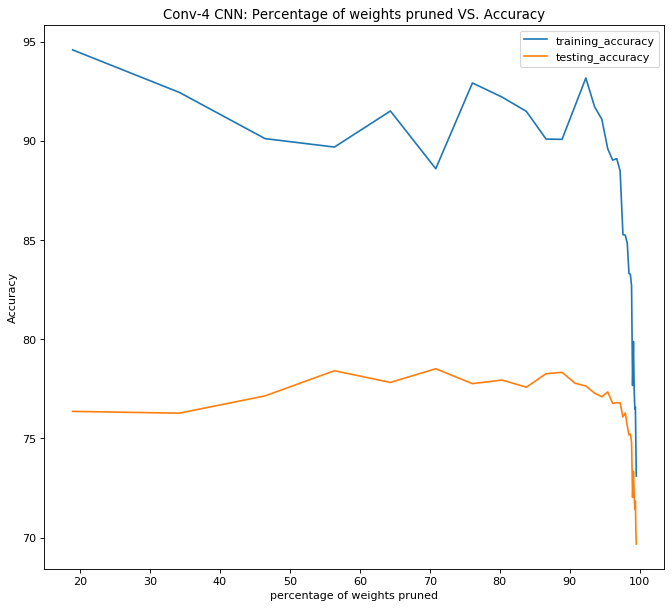

In [54]:
# Visualization of training and testing accuracy VS percentage of weights
# pruned-
fig=plt.figure(figsize=(10, 9), dpi= 80, facecolor='w', edgecolor='k')

plt.plot(list(plot_accuracy.keys()), list(plot_accuracy.values()), label = 'training_accuracy')
plt.plot(list(plot_test_accuracy.keys()), list(plot_test_accuracy.values()), label = 'testing_accuracy')

plt.title("Conv-4 CNN: Percentage of weights pruned VS. Accuracy")
plt.xlabel("percentage of weights pruned")
plt.ylabel("Accuracy")
plt.legend(loc = 'best')
plt.show()

In [55]:
# Python 3 dict for training and testing loss visualization-
plot_loss = {}
plot_test_loss = {}

In [56]:
# populate 'plot_loss'-
for k in history_main.keys():
    epoch_length = len(history_main[k]['loss'])
    plot_loss[history_main[k]['percentage_wts_pruned']] = history_main[k]['loss'][epoch_length - 1]


In [57]:
# populate 'plot_test_loss'-
for k in history_main.keys():
    epoch_length = len(history_main[k]['loss'])
    plot_test_loss[history_main[k]['percentage_wts_pruned']] = history_main[k]['val_loss'][epoch_length - 1]


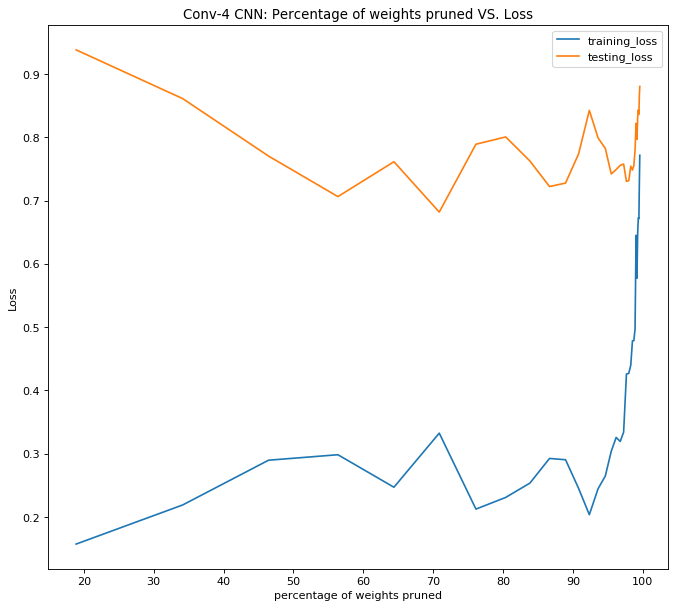

In [58]:
# Visualization of training and testing loss VS percentage of remaining weights-
# pruned-
fig=plt.figure(figsize=(10, 9), dpi= 80, facecolor='w', edgecolor='k')

plt.plot(list(plot_loss.keys()), list(plot_loss.values()), label = 'training_loss')
plt.plot(list(plot_test_loss.keys()), list(plot_test_loss.values()), label = 'testing_loss')

plt.title("Conv-4 CNN: Percentage of weights pruned VS. Loss")
plt.xlabel("percentage of weights pruned")
plt.ylabel("Loss")
plt.legend(loc = 'best')
plt.show()

In [59]:
# Plot number of epochs (Early Stopping) VS percentage of weights pruned-

# Python 3 dict to hold number of epochs vs % of weights pruned-
# Experiment-1
plot_num_epochs = {}
# plot_num_epochs_test = {}

# populate 'plot_num_epochs'-
for k in history_main.keys():
    num_epochs = len(history_main[k]['accuracy'])
    plot_num_epochs[history_main[k]['percentage_wts_pruned']] = num_epochs


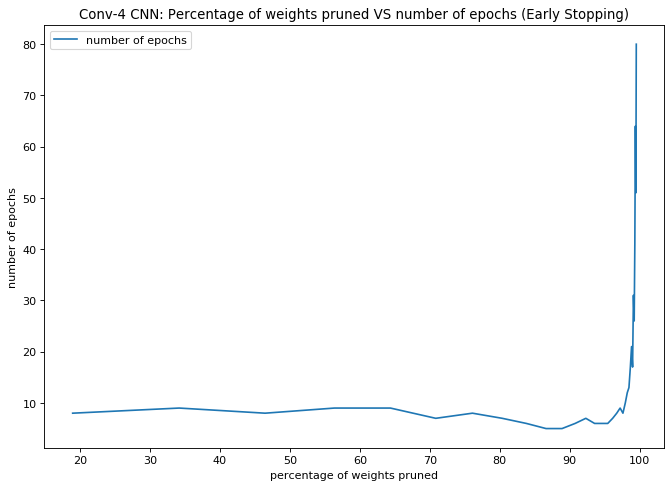

In [60]:
# Visualize percentage of weights remaining VS number of epochs (Early Stopping)
fig=plt.figure(figsize=(10, 7), dpi= 80, facecolor='w', edgecolor='k')

plt.plot(list(plot_num_epochs.keys()), list(plot_num_epochs.values()), label = 'number of epochs')
# plt.plot(list(plot_test_accuracy.keys()), list(plot_test_accuracy.values()), label = 'validation accuracy')
# plt.plot(list(plot_test_loss.keys()), list(plot_test_loss.values()), label = 'validation loss')

plt.title("Conv-4 CNN: Percentage of weights pruned VS number of epochs (Early Stopping)")
plt.xlabel("percentage of weights pruned")
plt.ylabel("number of epochs")
plt.legend(loc = 'best')
plt.show()


In [61]:
# Try to visualize the STARTING training and testing accuracy VS percentage
# of remaining weights-

# Python 3 dict for visualization-
plot_starting_accuracy = {}
plot_starting_test_accuracy = {}

# Key:    percentage of weights pruned
# Value:  starting accuracy


In [62]:
# populate 'plot_starting_accuracy'-
for k in history_main.keys():
    epoch_length = len(history_main[k]['loss'])
    plot_starting_accuracy[history_main[k]['percentage_wts_pruned']] = history_main[k]['accuracy'][0]


In [63]:
# populate 'plot_starting_test_accuracy'-
for k in history_main.keys():
    epoch_length = len(history_main[k]['loss'])
    plot_starting_test_accuracy[history_main[k]['percentage_wts_pruned']] = history_main[k]['val_accuracy'][0]


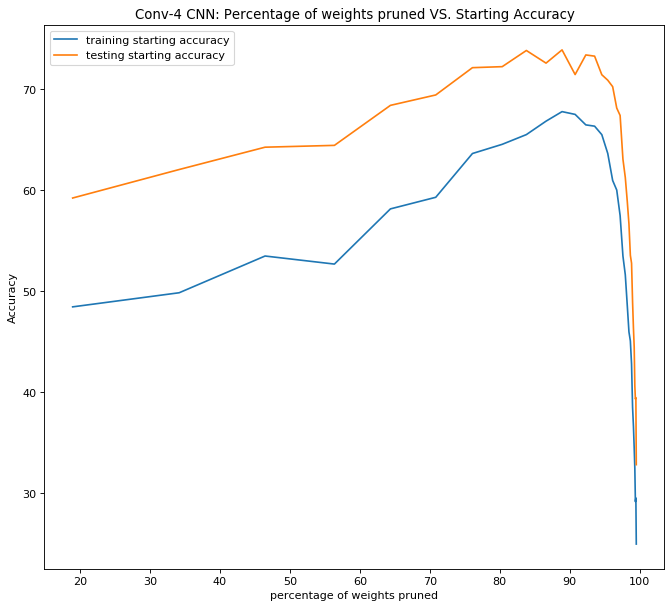

In [64]:
# Visualize starting accuracy VS percentage of weights pruned-
fig=plt.figure(figsize=(10, 9), dpi= 80, facecolor='w', edgecolor='k')

plt.plot(list(plot_starting_accuracy.keys()), list(plot_starting_accuracy.values()), label = 'training starting accuracy')
plt.plot(list(plot_starting_test_accuracy.keys()), list(plot_starting_test_accuracy.values()), label = 'testing starting accuracy')

plt.title("Conv-4 CNN: Percentage of weights pruned VS. Starting Accuracy")
plt.xlabel("percentage of weights pruned")
plt.ylabel("Accuracy")
plt.legend(loc = 'best')
plt.show()


In [65]:
# Try to visualize the STARTING training and testing loss VS percentage
# of remaining weights-

# Python 3 dict for visualization-
plot_starting_loss = {}
plot_starting_test_loss = {}

# Key:		percentage of weights pruned
# Value:	starting loss


In [66]:
# Populate 'plot_starting_loss' Python 3 dict-
for k in history_main.keys():
    epoch_length = len(history_main[k]['loss'])
    plot_starting_loss[history_main[k]['percentage_wts_pruned']] = history_main[k]['loss'][0]


In [67]:
# Populate 'plot_starting_test_loss' Python 3 dict-
for k in history_main.keys():
    epoch_length = len(history_main[k]['loss'])
    plot_starting_test_loss[history_main[k]['percentage_wts_pruned']] = history_main[k]['val_loss'][0]


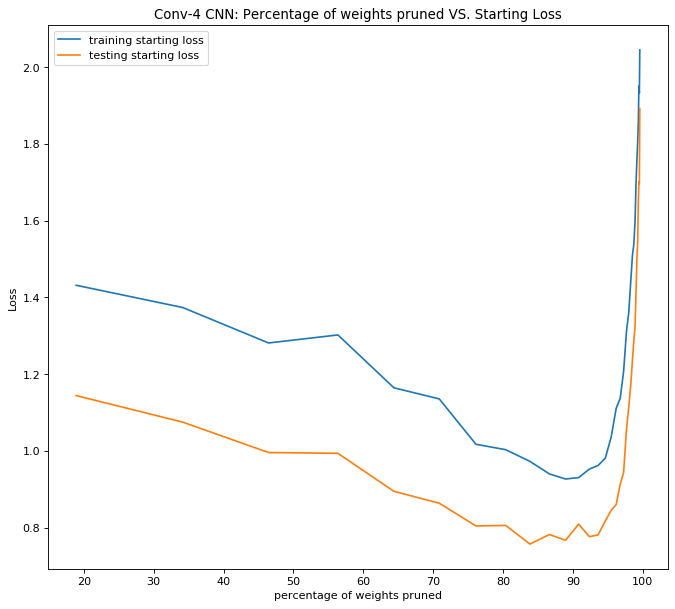

In [68]:
# Visualize Starting training & testing loss VS percentage of weights pruned-
fig=plt.figure(figsize=(10, 9), dpi= 80, facecolor='w', edgecolor='k')

plt.plot(list(plot_starting_loss.keys()), list(plot_starting_loss.values()), label = 'training starting loss')
plt.plot(list(plot_starting_test_loss.keys()), list(plot_starting_test_loss.values()), label = 'testing starting loss')

plt.title("Conv-4 CNN: Percentage of weights pruned VS. Starting Loss")
plt.xlabel("percentage of weights pruned")
plt.ylabel("Loss")
plt.legend(loc = 'best')
plt.show()

In [69]:
# Try to visualize: percentage of weights remaining VS BEST accuracy within each iterative
# pruning round

# Python 3 dict for visualization-
plot_best_accuracy = {}
plot_best_test_accuracy = {}

# Key:		percentage of weights pruned
# Value:	best accuracy

In [70]:
# Populate 'plot_best_accuracy' Python 3 dict-
for k in history_main.keys():
    epoch_length = len(history_main[k]['accuracy'])
    plot_best_accuracy[history_main[k]['percentage_wts_pruned']] = np.amax(history_main[k]['accuracy'])


In [71]:
# Populate 'plot_best_test_accuracy' Python 3 dict-
for k in history_main.keys():
    epoch_length = len(history_main[k]['accuracy'])
    plot_best_test_accuracy[history_main[k]['percentage_wts_pruned']] = np.amax(history_main[k]['val_accuracy'])


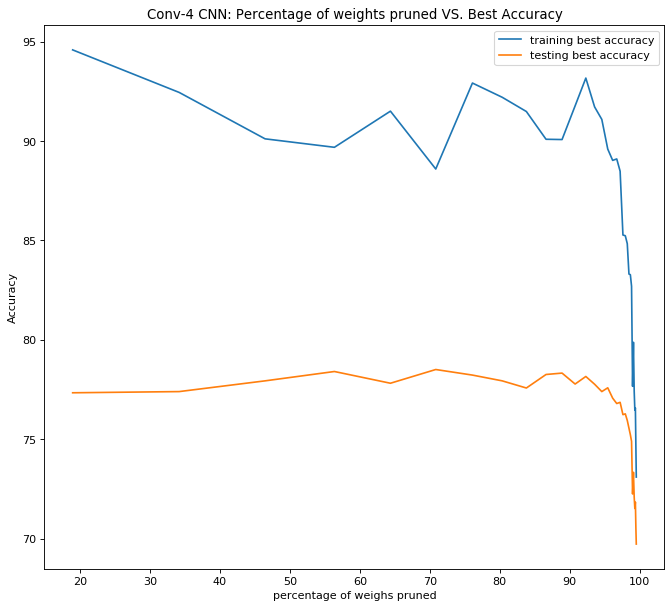

In [72]:
# Visualize best accuracy VS percentage of weights pruned-
fig=plt.figure(figsize=(10, 9), dpi= 80, facecolor='w', edgecolor='k')

plt.plot(list(plot_best_accuracy.keys()), list(plot_best_accuracy.values()), label = 'training best accuracy')
plt.plot(list(plot_best_test_accuracy.keys()), list(plot_best_test_accuracy.values()), label = 'testing best accuracy')

plt.title("Conv-4 CNN: Percentage of weights pruned VS. Best Accuracy")
plt.xlabel("percentage of weighs pruned")
plt.ylabel("Accuracy")
plt.legend(loc = 'best')
plt.show()


In [73]:
# Try to visualize: percentage of weights remaining VS LOWEST loss within each iterative
# pruning round

# Python 3 dict for visualization-
plot_best_loss = {}
plot_best_test_loss = {}

# Key:		percentage of weights pruned
# Value:	best loss

In [74]:
# Populate 'plot_best_loss' Python 3 dict-
for k in history_main.keys():
    epoch_length = len(history_main[k]['loss'])
    plot_best_loss[history_main[k]['percentage_wts_pruned']] = np.amin(history_main[k]['loss'])


In [75]:
# Populate 'plot_best_test_loss' Python 3 dict-
for k in history_main.keys():
    epoch_length = len(history_main[k]['loss'])
    plot_best_test_loss[history_main[k]['percentage_wts_pruned']] = np.amin(history_main[k]['val_loss'])


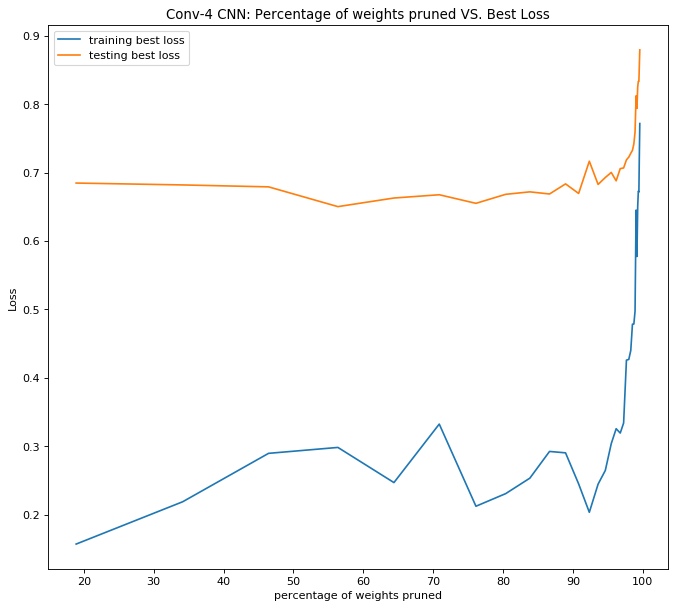

In [76]:
# Visualize best loss VS percentage of weights pruned-
fig=plt.figure(figsize=(10, 9), dpi= 80, facecolor='w', edgecolor='k')

plt.plot(list(plot_best_loss.keys()), list(plot_best_loss.values()), label = 'training best loss')
plt.plot(list(plot_best_test_loss.keys()), list(plot_best_test_loss.values()), label = 'testing best loss')

plt.title("Conv-4 CNN: Percentage of weights pruned VS. Best Loss")
plt.xlabel("percentage of weights pruned")
plt.ylabel("Loss")
plt.legend(loc = 'best')
plt.show()


### Finding the _winning ticket_:

In [77]:
for k in history_main.keys():
	epoch_length = len(history_main[k]['loss'])

	if k == 1:
		print("epoch: {0}, val_acc = {1:.4f}% with {2:.4f}% weights pruned, needs = {3} epochs".format(
			k, history_main[k]['val_accuracy'][epoch_length-1],
			0, epoch_length))
	else:
		print("epoch: {0}, val_acc = {1:.4f}% with {2:.4f}% weights pruned, needs = {3} epochs".format(
			k, history_main[k]['val_accuracy'][epoch_length-1],
			history_main[k - 1]['percentage_wts_pruned'], epoch_length))


epoch: 1, val_acc = 76.3600% with 0.0000% weights pruned, needs = 8 epochs
epoch: 2, val_acc = 76.2700% with 18.9112% weights pruned, needs = 9 epochs
epoch: 3, val_acc = 77.1400% with 34.1484% weights pruned, needs = 8 epochs
epoch: 4, val_acc = 78.4100% with 46.4360% weights pruned, needs = 9 epochs
epoch: 5, val_acc = 77.8200% with 56.3550% weights pruned, needs = 9 epochs
epoch: 6, val_acc = 78.5100% with 64.3704% weights pruned, needs = 7 epochs
epoch: 7, val_acc = 77.7600% with 70.8531% weights pruned, needs = 8 epochs
epoch: 8, val_acc = 77.9400% with 76.1015% weights pruned, needs = 7 epochs
epoch: 9, val_acc = 77.5800% with 80.3590% weights pruned, needs = 6 epochs
epoch: 10, val_acc = 78.2600% with 83.8155% weights pruned, needs = 5 epochs
epoch: 11, val_acc = 78.3300% with 86.6282% weights pruned, needs = 5 epochs
epoch: 12, val_acc = 77.7800% with 88.9195% weights pruned, needs = 6 epochs
epoch: 13, val_acc = 77.6400% with 90.7905% weights pruned, needs = 7 epochs
epoch: 14